# Calculate a subject-to-subject similarity matrix for SPSQ-SF questionnaire scores

https://naturalistic-data.org/content/Intersubject_RSA.html#calculate-behavioral-similarity

Load modules

In [1]:
import os
import glob
from pathlib import Path

import numpy as np
from scipy.stats import rankdata, ttest_rel, ttest_1samp, zscore
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import seaborn as sns

import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

%matplotlib inline

In [5]:
data_dir = '/project/3013104.01/analysis/'
os.chdir(data_dir)
questionnaire_data = pd.read_csv(os.path.join(data_dir, 'SPSQ-24_all.csv'))
questionnaire_data.head()

,subject,as_SPS13_emotionally_touched_music_art,as_SPS29_notice_subtle_touching_tones_music,as_SPS31_very_movedy_nice_work_of_art,SPSQ_as,ep_SPS02_nervous_to_many_things_at_once,ep_SPS24_rushed_too_much_little_time,ep_SPS28_upset_when_people_ask_many_things_at_once,SPSQ_ep,sa_SPS03_see_sad_eyes_behind_smile,...,sd_SPS25_suffer_bright_light,SPSQ_sd,ss_SPS14_immediately_feel_mouth_throat_drier,ss_SPS15_hardly_visible_details_attract_attention,ss_SPS21_quickly_aware_changes_body,ss_SPS23_notice_faints_smells,SPSQ_ss,SPSQ_sum,SPSQ_pos,SPSQ_neg
0,subject-0001,1,1,1,3,1,1,4,6,1,...,1,7,7,6,4,7,24,79,66,13
1,subject-0002,2,2,1,5,1,2,4,7,4,...,4,15,4,4,4,5,17,96,74,22
2,subject-0003,6,6,6,18,1,3,4,8,1,...,4,20,4,6,6,6,22,125,97,28
3,subject-0004,4,4,4,12,4,4,4,12,4,...,3,13,4,3,4,4,15,103,78,25
4,subject-0005,3,5,2,10,3,6,4,13,6,...,5,21,6,6,5,3,20,123,89,34


Check distributions of each variable of interest. If they are not normally distributed, then convert to ranks. If they are normally distributed, then do not convert to ranks.

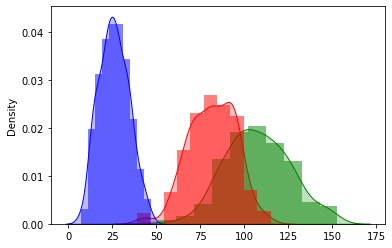

In [3]:
# Separate DataFrames for each variable
SPSQ_sum_data = questionnaire_data['SPSQ_sum']
SPSQ_pos_data = questionnaire_data['SPSQ_pos']
SPSQ_neg_data = questionnaire_data['SPSQ_neg']

# Convert the pandas Series to numpy arrays
SPSQ_sum_data = SPSQ_sum_data.values
SPSQ_pos_data = SPSQ_pos_data.values
SPSQ_neg_data = SPSQ_neg_data.values

# Plot the histograms using numpy.histogram
plt.figure()
plt.hist(SPSQ_sum_data, color='green', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_pos_data, color='red', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_neg_data, color='blue', bins=10, alpha=0.5, density=True)

# Plot the KDEs using seaborn kdeplot
sns.kdeplot(SPSQ_sum_data, color='green', fill=True)
sns.kdeplot(SPSQ_pos_data, color='red', fill=True)
sns.kdeplot(SPSQ_neg_data, color='blue', fill=True)

plt.show()

This data are normally distributed, so do not convert to ranks. Instead, raw scores can be converted to z-scores.

In [6]:
# Convert DataFrame to z-scores
questionnaire_data_z = questionnaire_data.copy()  # Create a copy of the original DataFrame

# Iterate over columns (except the first one)
for column in questionnaire_data_z.columns[1:]:
    questionnaire_data_z[column] = zscore(questionnaire_data_z[column])

questionnaire_data_z.head()

questionnaire_data_z.to_csv('SPSQ-24_all_z.csv', index=False)

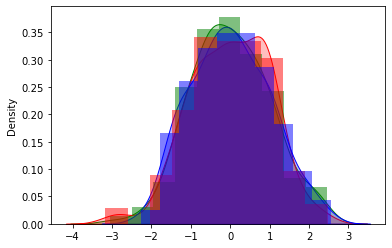

In [7]:
# Separate DataFrames for each variable
SPSQ_sum_data = questionnaire_data_z['SPSQ_sum']
SPSQ_pos_data = questionnaire_data_z['SPSQ_pos']
SPSQ_neg_data = questionnaire_data_z['SPSQ_neg']

# Convert the pandas Series to numpy arrays
SPSQ_sum_data = SPSQ_sum_data.values
SPSQ_pos_data = SPSQ_pos_data.values
SPSQ_neg_data = SPSQ_neg_data.values

# Plot the histograms using numpy.histogram
plt.figure()
plt.hist(SPSQ_sum_data, color='green', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_pos_data, color='red', bins=10, alpha=0.5, density=True)
plt.hist(SPSQ_neg_data, color='blue', bins=10, alpha=0.5, density=True)

# Plot the KDEs using seaborn kdeplot
sns.kdeplot(SPSQ_sum_data, color='green', fill=True)
sns.kdeplot(SPSQ_pos_data, color='red', fill=True)
sns.kdeplot(SPSQ_neg_data, color='blue', fill=True)

plt.show()

## Calculate questionnaire response similarity

### Euclidean distance (i.e., nearest neighbor)

Specify which questionnaire items to use

In [15]:
sum_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art', 'ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells']

positive_score = ['as_SPS13_emotionally_touched_music_art', 'as_SPS29_notice_subtle_touching_tones_music',
                       'as_SPS31_very_movedy_nice_work_of_art',
                       'sa_SPS03_see_sad_eyes_behind_smile', 'sa_SPS04_strikes_tone_voice_not_matching_words',
                       'sa_SPS09_looking_eyes_telling_truth', 'sa_SPS12_strikes_when_acting_not_afraid',
                       'sa_SPS22_tell_smile_masking_feelings', 'sc_SPS05_hard_enjoy_little_things_reversed',
                       'sc_SPS10_feel_good_with_people_I_love', 'sc_SPS17_enjoy_humour_situations',
                       'sc_SPS19_enjoy_relaxing_activity', 'sc_SPS30_watching_nice_movie_feels_good',
                       'ss_SPS14_immediately_feel_mouth_throat_drier',
                       'ss_SPS15_hardly_visible_details_attract_attention',
                       'ss_SPS21_quickly_aware_changes_body', 'ss_SPS23_notice_faints_smells']

negative_score = ['ep_SPS02_nervous_to_many_things_at_once',
                       'ep_SPS24_rushed_too_much_little_time', 'ep_SPS28_upset_when_people_ask_many_things_at_once',
                       'sd_SPS06_flashing_lights_bother', 'sd_SPS16_easily_disturbed_light_odors',
                       'sd_SPS20_loud_noises_irritating', 'sd_SPS25_suffer_bright_light']

Calculate similarity matrices

In [34]:
# Select columns from the data 
scores_df = data[negative_score]

# Calculate Euclidean distance matrix
euclidean_distance_matrix = cdist(scores_df, scores_df, metric='euclidean')

# Convert the Euclidean distances to similarities 
euclidean_distance_similarity = 1 / (1 + euclidean_distance_matrix)

# Convert the distance matrix to a pandas DataFrame
distance_matrix_df = pd.DataFrame(euclidean_distance_similarity, index=data['subject'], columns=data['subject'])

# Export to csv
distance_matrix_df.to_csv('distance_matrix_negative_score.csv', index=False)

(Sidenote: To convert Euclidean distance to similarities, the formula for similarity or affinity can be used (i.e., the "inverse distance" or "inverse proportionality" approach). In general, the more similar two points are, the closer their distance should be to zero. Therefore, the inverse of the Euclidean distance can be used to obtain a similarity score. Given two points, A and B, with their Euclidean distance d_euc(A, B), the distance can be converted to similarity (sim) so that sim(A,B)=1/(1+d_euc(A,B)). This makes interpetation more straightforward because positive similarity values will then reflects a higher representational similarity between brain and questionnaire.)

Plot the distance similarity matrices

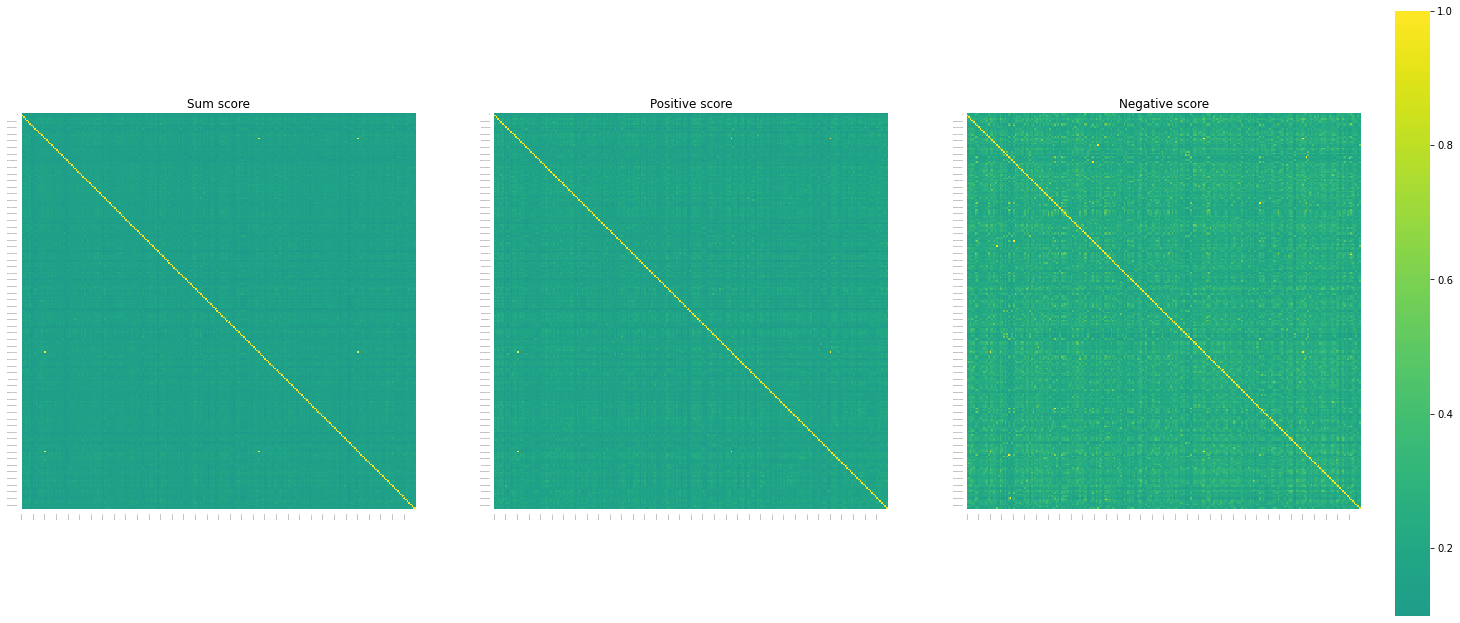

In [42]:
# Read three different matrix files
file1 = 'distance_matrix_sum_score.csv'
file2 = 'distance_matrix_positive_score.csv'
file3 = 'distance_matrix_negative_score.csv'

distance_matrix_df1 = pd.read_csv(file1, index_col=0)
distance_matrix_df2 = pd.read_csv(file2, index_col=0)
distance_matrix_df3 = pd.read_csv(file3, index_col=0)

# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

# Create a large heatmap for sum score
sns.heatmap(distance_matrix_df1, ax=axes[0], annot=False, cmap='viridis', center=0, cbar=False, square=True, linewidths=0)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='both', which='both', length=0, labelsize=0)
axes[0].set_title('Sum score') 

# Create a large heatmap for the positive dimension
sns.heatmap(distance_matrix_df2, ax=axes[1], annot=False, cmap='viridis', center=0, cbar=False, square=True, linewidths=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', which='both', length=0, labelsize=0)
axes[1].set_title('Positive score')  


# Create a large heatmap for the negative dimensions
sns.heatmap(distance_matrix_df3, ax=axes[2], annot=False, cmap='viridis', center=0, cbar_ax=fig.add_axes([0.92, 0.15, 0.02, 0.7]), square=True, linewidths=0)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].tick_params(axis='both', which='both', length=0, labelsize=0)
axes[2].set_title('Negative score')  

plt.show()